In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session
from qiskit.result.utils import marginal_distribution

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [2]:
def create_ghz_circuit(n):
    qc = QuantumCircuit(n,n-1)
    # Apply Hadamard gate to the first qubit
    qc.h(0)
    # Apply CNOT gates
    for i in range(1, n):
        qc.cx(0, i)
    qc.barrier()
    for i in range(1, n):
        qc.measure(i,i-1)
    
    #circuit.measure_all()
    return qc

def parallel_placement(small_circ, layout, backend):
    reps = len(layout)
    num_qubits = small_circ.num_qubits
    num_clbits = small_circ.num_clbits
    circuit = QuantumCircuit(num_qubits*reps, num_clbits*reps)
    for i in range(reps):
        circuit.compose(small_circ, range(i*num_qubits,(i+1)*num_qubits),range(i*num_clbits,(i+1)*num_clbits), 
                        inplace=True)
    initial_layout = []
    for value in layout:
        initial_layout+=value
    trans_circuit = transpile(circuit, backend, initial_layout=initial_layout)
    return trans_circuit

In [3]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [4]:
backend = service.get_backend('ibm_hanoi')

In [6]:
multiMap= [[12, 10, 13, 15], [1, 0, 4, 2]]
circuit = create_ghz_circuit(4)
circuit.draw()

┌───┐                ░          
q_0: ┤ H ├──■────■────■───░──────────
     └───┘┌─┴─┐  │    │   ░ ┌─┐      
q_1: ─────┤ X ├──┼────┼───░─┤M├──────
          └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
q_2: ──────────┤ X ├──┼───░──╫─┤M├───
               └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_3: ───────────────┤ X ├─░──╫──╫─┤M├
                    └───┘ ░  ║  ║ └╥┘
c: 3/════════════════════════╩══╩══╩═
                             0  1  2

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


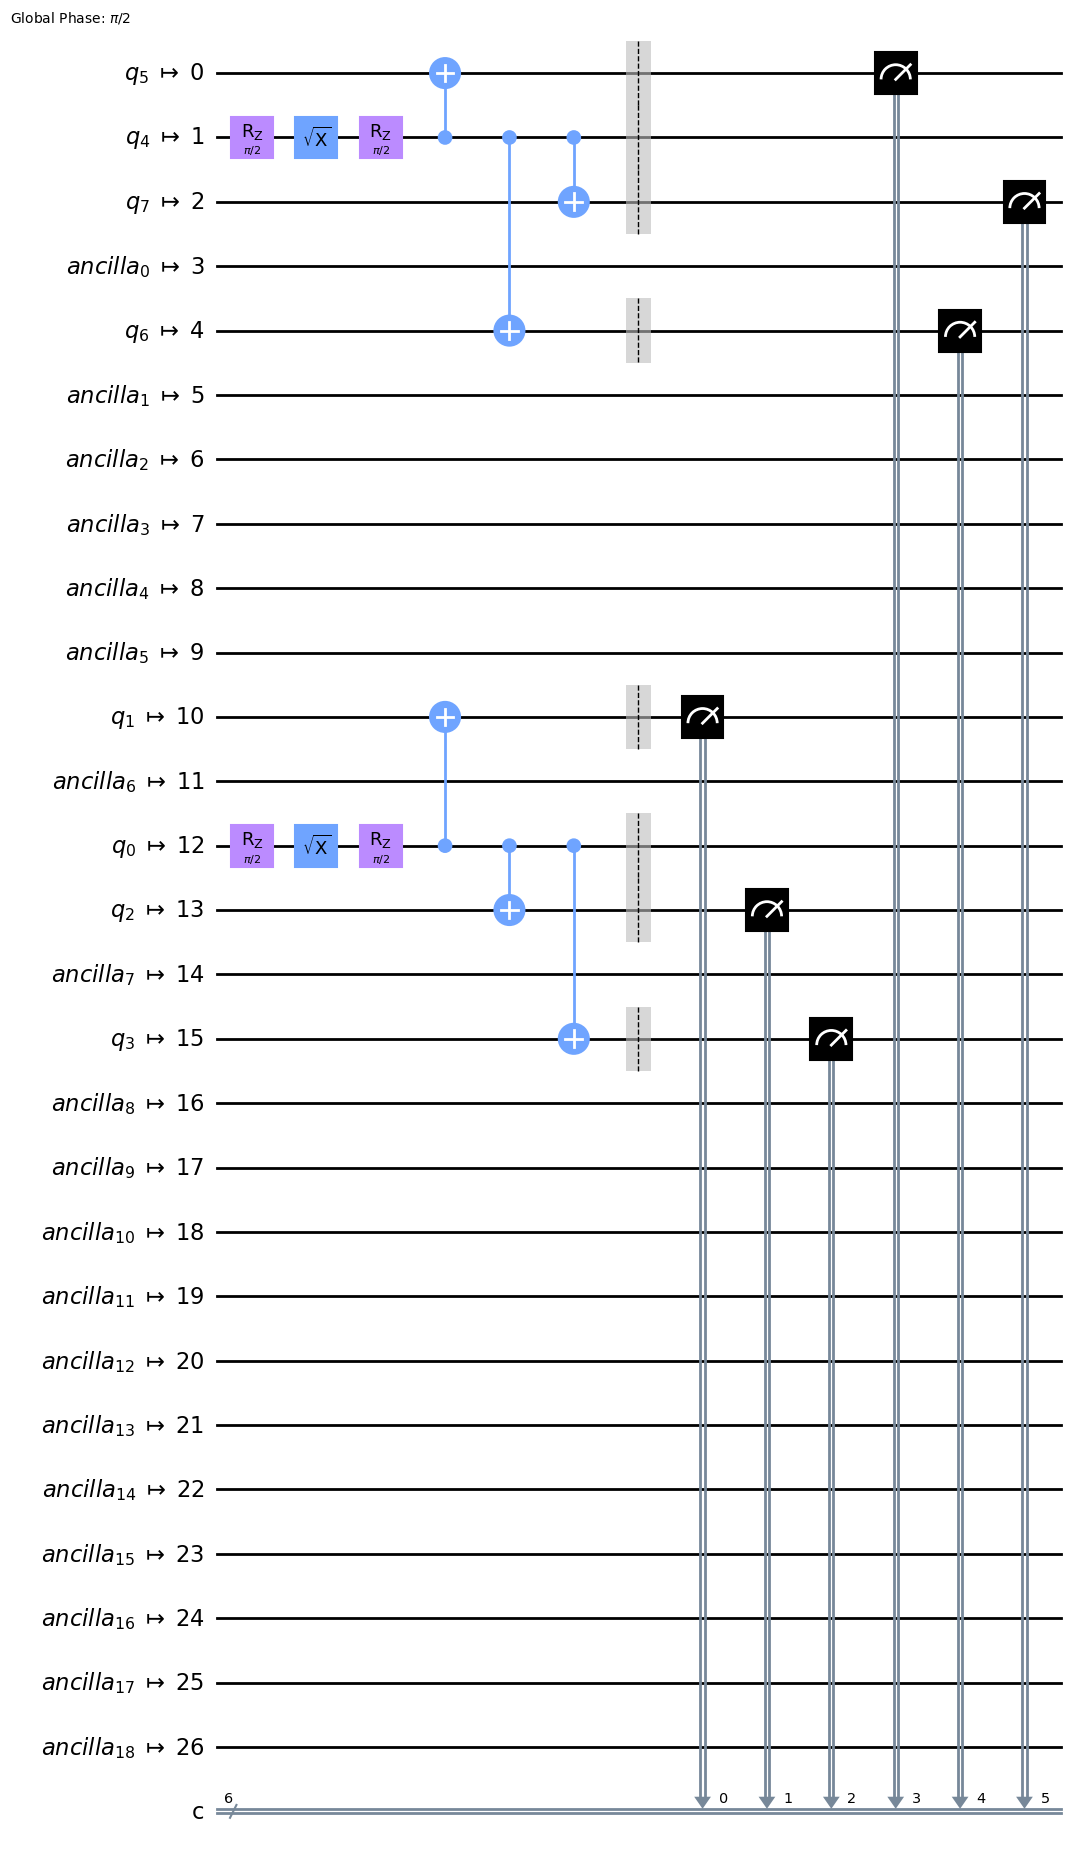

In [7]:
trans_circuit = parallel_placement(circuit, multiMap, backend)
trans_circuit.draw(output='mpl')

In [7]:
options = Options()
options.resilience_level = 1
options.transpilation.skip_transpilation = True
sampler = Sampler(backend, options=options)
job = sampler.run(trans_circuit)

In [8]:
result = job.result().quasi_dists

In [9]:
'''convert the integers to bitstrings,if you want to apply the marginal_counts 
   and get the probability distribution of specific circuit or bits'''
probs = {}
for key, value in job.result().quasi_dists[0].items():
    probs[format(key,'0'+str(trans_circuit.num_clbits)+'b')] = value

In [10]:
# circuit 1
marginal_distribution(probs, indices=[0,1,2])

{'001': 0.007498865867418932,
 '011': -1.321014170805156e-05,
 '010': 0.0024574923611258926,
 '000': 0.5001325771589235,
 '110': -0.006710918861489491,
 '111': 0.4876991257729335,
 '100': 0.002747360278153251,
 '101': 0.006188707564642575}

In [11]:
# circuit 2
marginal_distribution(probs, indices=[3,4,5])

{'001': 0.005176839043036119,
 '011': 0.005455837670589572,
 '010': 0.0015218348519292061,
 '000': 0.48574652608110314,
 '110': 0.0010823610950347418,
 '111': 0.4966675654768878,
 '100': 0.0034489250755593516,
 '101': 0.0009001107058601524}